# Text Clustering - BBC News Example

## 1. Environment Preparation



In [ ]:
# install and import packages
!pip install openpyxl wordcloud matplotlib scikit-learn nltk
import pandas as pd # working with data
import numpy as np # working with arrays

import matplotlib.pyplot as plt # data visualization
from wordcloud import WordCloud # text visualization

from sklearn.cluster import KMeans # data clustering
from sklearn.metrics import silhouette_score # cluster metric
from sklearn.decomposition import PCA # data reduction

# NLP packages
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Helper functions
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    en_stopwords = stopwords.words('english')
    # Remove punctuation, numbers, and special characters
    text = ''.join([c for c in text if c.isalpha() or c.isspace()])
    # Convert text to lowercase
    text = text.lower()
    # Tokenize the text into words
    words = nltk.word_tokenize(text)
    # Remove stop words
    words = [word for word in words if word not in en_stopwords]
    # Perform pos_tag to include nouns (NN, NNP, NNS) and verbs (VB, VBD, VBG, VBN, VBP, VBZ)
    words = [tagged_word[0] for tagged_word in pos_tag(words) if tagged_word[1].startswith('NN') or tagged_word[1].startswith('V') ]
    # Perform lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]
    # Remove stop words
    words = [word for word in words if word not in en_stopwords]
    # Remove words with length less than 2
    words = [word for word in words if len(word)>1]
    # Join the processed words back into a single string
    processed_text = ' '.join(words)
    return processed_text

def generate_subplot_index(total_no_of_subplots, no_of_cols):
  no_of_rows = total_no_of_subplots // no_of_cols
  if total_no_of_subplots % no_of_cols != 0:
    no_of_rows += 1
  subplot_index_list = range(1, total_no_of_subplots + 1)
  return no_of_rows, no_of_cols, subplot_index_list

def plot_clusters(X_vectorized, k, cluster_labels):
  # Reduce the dimensionality for visualization
  pca = PCA(n_components=2)
  X_reduced = pca.fit_transform(X_vectorized.toarray())
  # Plot the clusters
  scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=cluster_labels, cmap='viridis')
  plt.legend(handles=scatter.legend_elements()[0], labels=list(range(k)))
  plt.title('Cluster Visualization')
  plt.xlabel('Principal Component 1')
  plt.ylabel('Principal Component 2')
  return plt

def plot_clusters_silhouette_scores(min_clusters, max_clusters, silhouette_scores):
  # Plot the silhouette scores against the number of clusters
  plt.plot(range(min_clusters, max_clusters+1), silhouette_scores)
  plt.xlabel('Number of Clusters')
  plt.ylabel('Silhouette Score')
  plt.title('Silhouette Analysis')
  return plt

def plot_clusters_wcss_scores(min_clusters, max_clusters, wcss_scores):
  # Plot the WCSS values against the number of clusters
  plt.plot(range(min_clusters, max_clusters+1), wcss_scores)
  plt.xlabel('Number of Clusters')
  plt.ylabel('WCSS')
  plt.title('Elbow Method')
  return plt

def plot_wordcloud(text, title):
  # Generate a word cloud image
  wordcloud = WordCloud(background_color="white").generate(text)
  plt.imshow(wordcloud)
  plt.title(f'{title}')
  plt.axis('off')
  return plt

def report_cluster_external_validation(data, text_feature, X, k, cluster_labels, external_label_field_name):
  # Print the cluster assignments
  for i in range(k):
    cluster_samples = X[cluster_labels == i]
    labels = []
    for sample in cluster_samples:
      labels.append(data.loc[data[text_feature] == sample, external_label_field_name].iloc[0])
    print(f"Cluster {i+1} \n{np.array(np.unique(labels, return_counts=True)).T}")
    print()


## 2. Data Exploration

In [37]:
# Load data into Pandas's Dataframe
news_df = pd.read_excel('BBCNewsDataset.xlsx')

# Print information about the Panda Dataframe, including the number of records, number of columns, and data types
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      1440 non-null   object
 1   Category  1440 non-null   object
dtypes: object(2)
memory usage: 22.6+ KB


In [38]:
# Display the normalized counts of unique values of the label column
pd.DataFrame(news_df['Category'].value_counts(sort=True, normalize=True))

,Category
sport,0.237500
business,0.232639
politics,0.184722
entertainment,0.182639
tech,0.162500


In [39]:
# Specify features of interest
text_feature = 'Text'
processed_text_feature = text_feature + '_processed'
label = 'Category'

news_df.head(10)

,Text,Category
0,worldcom ex-boss launches defence lawyers defe...,business
1,german business confidence slides german busin...,business
2,bbc poll indicates economic gloom citizens in ...,business
3,lifestyle governs mobile choice faster bett...,tech
4,enron bosses in $168m payout eighteen former e...,business
5,howard truanted to play snooker conservative...,politics
6,wales silent on grand slam talk rhys williams ...,sport
7,french honour for director parker british film...,entertainment
8,car giant hit by mercedes slump a slump in pro...,business
9,fockers fuel festive film chart comedy meet th...,entertainment


## 3. Data Preparation

In [ ]:
# Preprocess text
news_df[processed_text_feature] = news_df[text_feature].apply(lambda x: preprocess_text(x))
news_df.head(10)

,Text,Category,Text_processed
0,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launch defence lawyer defendin...
1,german business confidence slides german busin...,business,business confidence business confidence fell k...
2,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates gloom citizen majority nati...
3,lifestyle governs mobile choice faster bett...,tech,governs choice hardware going help phone firm ...
4,enron bosses in $168m payout eighteen former e...,business,enron boss payout enron director agreed settle...
5,howard truanted to play snooker conservative...,politics,truanted play snooker leader michael admitted ...
6,wales silent on grand slam talk rhys williams ...,sport,wale slam talk rhys williams say wale thinking...
7,french honour for director parker british film...,entertainment,honour director parker film director sir alan ...
8,car giant hit by mercedes slump a slump in pro...,business,car giant hit mercedes slump profitability lux...
9,fockers fuel festive film chart comedy meet th...,entertainment,fockers fuel film chart comedy meet fockers to...


## 4. KMeans Model Development and Scoring


In [21]:
# Create an array of your processed text feature
X = news_df[processed_text_feature].values

In [22]:
# Use TfidfVectorizer to vectorize the text data
vectorizer = TfidfVectorizer() #CountVectorizer()
X_vectorized = vectorizer.fit_transform(X)

In [31]:
# Train different KMeans models with different numbers of clusters and calculate cluster quality scores (e.g., silhouette & wcss)
min_clusters = 2
max_clusters = 10

silhouette_scores = []
wcss_scores = []  # within-cluster sum of squares
cluster_labels_ = []
cluster_centers_ = []

for k in range(min_clusters, max_clusters+1):
    # Cluster the data using K-means
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(X_vectorized)

    # Get the cluster labels
    cluster_labels = kmeans.labels_
    cluster_labels_.append(cluster_labels)

    # Get the cluster centers
    cluster_centers = kmeans.cluster_centers_
    cluster_centers_.append(cluster_centers)

    # Calculate the silhouette score
    silhouette = silhouette_score(X_vectorized, cluster_labels)
    silhouette_scores.append(silhouette)

    # Get the within-cluster sum of squares
    wcss = kmeans.inertia_
    wcss_scores.append(wcss)

In [34]:
# Print cluster quality scores (e.g., silhouette & wcss) and find optimal model
print()
print(f"silhouette_scores: {silhouette_scores}")
print(f"wcss_scores: {wcss_scores}")

best_silhouette_score = max(silhouette_scores)
cluster_labels = cluster_labels_[np.argmax(silhouette_scores)]
cluster_centers = cluster_centers_[np.argmax(silhouette_scores)]
optimal_num_clusters = np.argmax(silhouette_scores) + min_clusters

print(f"Optimal Number of Clusters: {optimal_num_clusters} \t Best Silhouette Score: {best_silhouette_score}")
print()


silhouette_scores: [0.00884158042738201, 0.00880714852134253, 0.008521554312273145, 0.011216060129422934, 0.014227495604279236, 0.013871998908255995, 0.01477915633679417, 0.013975721622798191, 0.0133868774749079]
wcss_scores: [1391.1680975735007, 1379.638834420237, 1378.8576046493158, 1367.8852032759619, 1357.2916597765632, 1352.6630073757076, 1346.4533002997669, 1342.2804733137064, 1338.2974778880969]
Optimal Number of Clusters: 8 	 Best Silhouette Score: 0.01477915633679417



## 5. Optimal Model Selection & Clusters Visualization

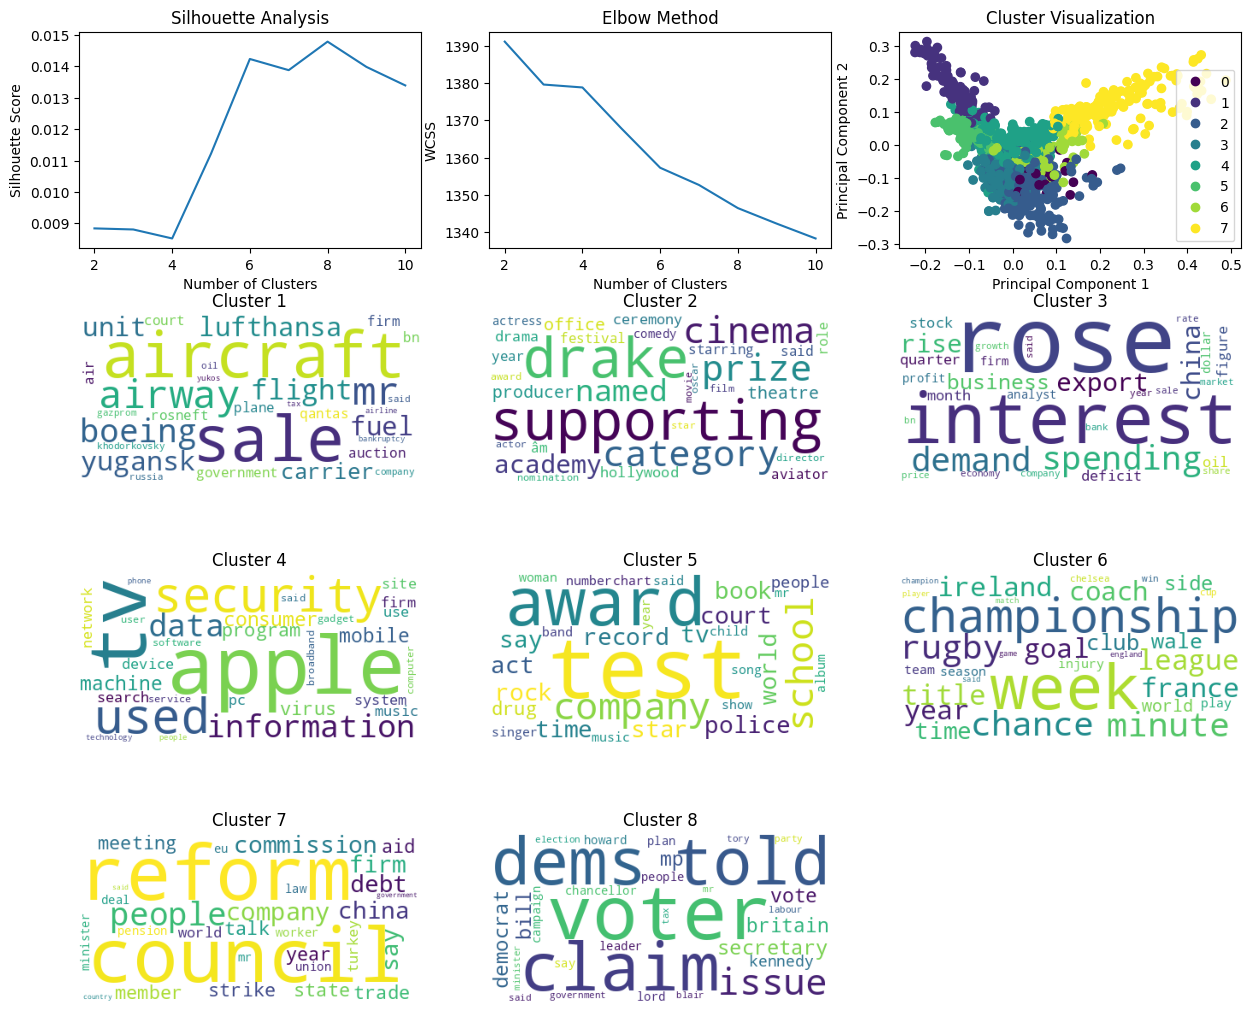

In [35]:
# Visualize clusters qualitymetrics
k = optimal_num_clusters

# Generate subplot indices for PCA, Silhoutte scores, WCSS, and the wordcloud plots for k clusters
no_of_rows, no_of_cols, subplot_index_list = generate_subplot_index(total_no_of_subplots=k+3, no_of_cols=3)
fig = plt.figure(1, figsize=(15, 3*no_of_rows))
plt.subplots_adjust(bottom=0.05)

# Plot the silhouette scores against the number of clusters
ax = fig.add_subplot(no_of_rows, no_of_cols, subplot_index_list[0])
ax.plot = plot_clusters_silhouette_scores(min_clusters, max_clusters, silhouette_scores)

# Plot the WCSS values against the number of clusters
ax = fig.add_subplot(no_of_rows, no_of_cols, subplot_index_list[1])
ax.plot = plot_clusters_wcss_scores(min_clusters, max_clusters, wcss_scores)

# Plot the clusters
ax = fig.add_subplot(no_of_rows, no_of_cols, subplot_index_list[2])
ax.plot = plot_clusters(X_vectorized, k, cluster_labels)

# Get the most representative words for each cluster
feature_names = vectorizer.get_feature_names_out()
num_words = 30  # Number of words to include in the word cloud

# Create a word clouds plot for each cluster's top words
for i, center in enumerate(cluster_centers):
  top_words_idx = center.argsort()[-num_words:]
  cluster_top_words = [feature_names[idx] for idx in top_words_idx]
  ax = fig.add_subplot(no_of_rows, no_of_cols, subplot_index_list[i+3])
  ax.plot = plot_wordcloud(' '.join(cluster_top_words), f'Cluster {i+1}')

## 6. External Validation of Generated Clusters with the News Label Field  

In [36]:
# Print the cluster external validation results
report_cluster_external_validation(news_df, processed_text_feature, X, k, cluster_labels, label)

Cluster 1 
[['business' '35']
 ['tech' '1']]

Cluster 2 
[['business' '1']
 ['entertainment' '109']
 ['tech' '3']]

Cluster 3 
[['business' '213']
 ['entertainment' '3']
 ['sport' '1']
 ['tech' '4']]

Cluster 4 
[['business' '3']
 ['politics' '2']
 ['tech' '184']]

Cluster 5 
[['business' '37']
 ['entertainment' '151']
 ['politics' '65']
 ['sport' '28']
 ['tech' '18']]

Cluster 6 
[['politics' '2']
 ['sport' '311']
 ['tech' '18']]

Cluster 7 
[['business' '45']
 ['politics' '41']
 ['sport' '2']
 ['tech' '6']]

Cluster 8 
[['business' '1']
 ['politics' '156']]

